In [78]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install pandas

In [79]:
import collections
import math
import os
import random
import zipfile
from six.moves import urllib
from six.moves import xrange
import numpy as np
import tensorflow as tf

In [80]:
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ',  url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify file from: ' + url_path + '. Can you get to it with a browser')

In [81]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
        
        return words

In [82]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016
maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


In [83]:
vocabulary = read_words()

In [84]:
len(vocabulary)

17005207

In [85]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

In [86]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words -  1))
    
    dictionary = dict()
    
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
        
    word_indexes = list()
        
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 # dictionary['UNKNOWN']
            unknown_count += 1
            
        word_indexes.append(index)
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return word_counts, word_indexes, dictionary, reversed_dictionary
    

In [87]:
VOCABULARY_SIZE = 10000
word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [88]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [89]:
word_indexes[:25]

[5234,
 3081,
 12,
 6,
 195,
 2,
 3134,
 46,
 59,
 156,
 128,
 742,
 477,
 0,
 134,
 1,
 0,
 2,
 1,
 103,
 855,
 3,
 1,
 0,
 0]

In [90]:
import random

for key in random.sample(list(dictionary), 10):
    print(key, ':', dictionary[key])

minerals : 3950
slave : 3256
seeking : 3627
turing : 3742
proposition : 7352
amongst : 2816
born : 267
smith : 1011
moment : 2724
jesuit : 7403


In [91]:
import random

for key in random.sample(list(reversed_dictionary), 10):
    print(key, ':', reversed_dictionary[key])

8058 : explorers
2594 : consumption
9413 : blame
8854 : refusal
8344 : intelsat
4705 : lasting
5732 : incomplete
6340 : challenges
3667 : legendary
5441 : fruits


In [92]:
del vocabulary

In [93]:
# Global index into words maintained across batches
global_index = 0 

In [94]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index

    # For every input we find num_skips context words within a window
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # batch = [1, 2, 3, .... batch_size]
    # labels = [[1], [2], [3], ..., [batch_size]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The span of a window includes the skip_window elements on each side
    # of the input word plus the word itself
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]

    # A deque is double-ended queue which supports memory efficient appends
    # and pops from each side
    buffer = collections.deque(maxlen=span)

    # Initialize the deque with the first words in the deque
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]

        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
        
        # The first word from the buffer is removed automatically when a new word
        # is added in at the end
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch, these
    # words will be captured in the next batch
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)

    return batch, labels

In [95]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [96]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [97]:
labels

array([[  59],
       [  12],
       [  12],
       [ 742],
       [   2],
       [ 128],
       [ 742],
       [3134],
       [   2],
       [   0]])

In [98]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ': ', reversed_dictionary[labels[i][0]])

of :  used
of :  as
abuse :  as
abuse :  working
first :  of
first :  early
used :  working
used :  abuse
against :  of


In [99]:
global_index = 0
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [100]:
num_samples = 64 # number of corrupted sample pairs to feed into the NCE

In [101]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

In [102]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [103]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [104]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [105]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32_ref>

In [106]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 50) dtype=float32>

In [107]:
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [108]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(
        weights=nce_weights,
        biases=nce_biases,
        labels=train_labels,
        inputs=embed,
        num_sampled=num_samples,
        num_classes=VOCABULARY_SIZE))

In [109]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [110]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))

normalized_embeddings = embeddings / l2_norm

In [111]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [112]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1:0' shape=(16, 50) dtype=float32>

In [113]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [114]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [115]:
init = tf.global_variables_initializer()

In [116]:
num_steps = 200001

In [118]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += loss_val
        
        # average loss at every step
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
        
        # note that this is expensive (compute heavy)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                
                # argsort sorts from highest to lowest, flip the sign so the largest distance away is the smallest number
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                
                log_str = 'Nearest to %s' % valid_word
                
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
                
            print('\n')
                    
    final_embeddings = normalized_embeddings.eval()
        

Average loss at step  0 :  211.421691895
Nearest to their extreme, algebra, empress, within, ic, ko, ticket, kent,
Nearest to is union, concern, annexed, proposals, home, natives, architects, jedi,
Nearest to more highways, carey, one, colts, croatian, helps, potter, pursued,
Nearest to than down, programme, teaching, locally, chlorine, correctly, producers, lights,
Nearest to some thinkers, bismarck, crusade, quartet, sam, directing, diminished, linguistics,
Nearest to other addiction, spectacular, legally, optimal, billion, oxidation, herbert, buried,
Nearest to zero kane, martial, driven, offices, copies, literacy, expensive, generalized,
Nearest to by famine, vi, presidency, connections, genesis, chains, iceland, fossils,
Nearest to it fleming, shooter, finance, plates, armoured, physically, reasoning, fe,
Nearest to with aided, introductory, puerto, hung, subsequent, away, aging, holmes,
Nearest to had rendering, specified, diary, twins, mus, mirror, promised, downtown,
Nearest to

Average loss at step  52000 :  5.47094173741
Average loss at step  54000 :  5.30654977369
Average loss at step  56000 :  5.37181170273
Average loss at step  58000 :  5.35968945634
Average loss at step  60000 :  5.1492719543
Nearest to their prince, within, fbi, because, algebra, issue, greece, frank,
Nearest to is union, concern, an, was, home, in, results, are,
Nearest to more highways, writers, wanted, arabic, server, way, greenland, berlin,
Nearest to than down, book, recently, took, part, each, caused, might,
Nearest to some people, fans, load, ieee, harry, evidence, danish, thinkers,
Nearest to other billion, african, herbert, george, duplicate, n, legally, page,
Nearest to zero four, two, literacy, five, six, blood, one, nine,
Nearest to by brief, country, assembled, and, jesus, implement, nuclear, native,
Nearest to it questions, ethnic, hits, we, powers, reasoning, areas, dividing,
Nearest to with classical, brother, away, implies, something, series, decimal, effect,
Nearest to

Average loss at step  112000 :  4.76791553092
Average loss at step  114000 :  4.79294438803
Average loss at step  116000 :  4.88700121474
Average loss at step  118000 :  4.72684439385
Average loss at step  120000 :  4.82928825521
Nearest to their moses, fbi, prince, issue, because, greece, frank, algebra,
Nearest to is was, union, are, concern, results, home, eighth, an,
Nearest to more highways, writers, wanted, arabic, embassy, server, walls, potter,
Nearest to than down, recently, plains, nelson, programme, took, producers, eastern,
Nearest to some load, people, thinkers, harry, expensive, conjunction, fans, ieee,
Nearest to other billion, speaks, herbert, african, legally, george, duplicate, markets,
Nearest to zero four, two, six, five, literacy, seven, nine, eight,
Nearest to by brief, and, assembled, country, from, implement, jesus, stop,
Nearest to it questions, that, dividing, hits, ethnic, we, fe, blues,
Nearest to with implies, classical, bias, brother, decimal, something, a

Average loss at step  172000 :  4.79859703588
Average loss at step  174000 :  4.71843234694
Average loss at step  176000 :  4.76785620451
Average loss at step  178000 :  4.7904667896
Average loss at step  180000 :  4.7807831074
Nearest to their moses, issue, fbi, prince, firms, because, greece, frank,
Nearest to is was, are, union, results, home, concern, enacted, garbage,
Nearest to more highways, writers, buddha, wanted, embassy, potter, server, walls,
Nearest to than down, recently, plains, programme, influx, producers, nelson, latvian,
Nearest to some load, people, harry, expensive, improvement, mediation, legs, thinkers,
Nearest to other speaks, addiction, billion, legally, african, herbert, markets, chat,
Nearest to zero four, six, two, five, seven, eight, literacy, three,
Nearest to by assembled, brief, country, from, implement, and, gnome, jesus,
Nearest to it questions, that, we, dividing, fe, this, hits, ethnic,
Nearest to with classical, bias, implies, batting, decimal, brot

In [120]:
def save_word_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
save_word_embeddings(final_embeddings, word_counts)

In [124]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.jpg'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18, 18))
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.savefig(filename)
    plt.show(filename)

In [125]:
!pip install sklearn
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dims_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

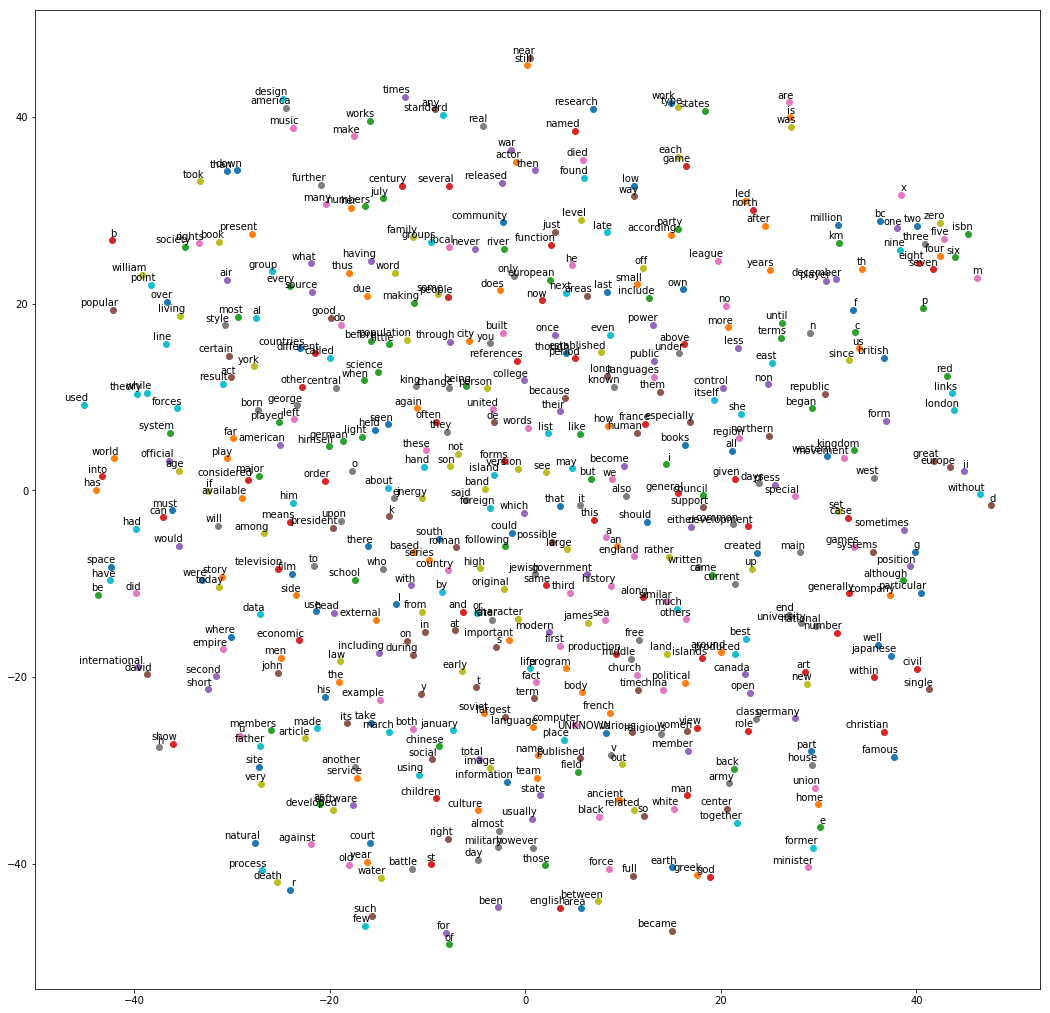

In [126]:
plot_with_labels(low_dims_embs, labels)